#### Ace0 model comparison

In [2]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
from modules.cdaf import plot_cdaf
import scipy.stats as st

# set plotting theme
from matplotlib.ticker import MultipleLocator
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
# default_color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/ace0/model"
dpi = 600
savefig = False
kernel_n = 6

#### Setup data

In [3]:
test_id = {
    0: "SA-HMOGP",
    1: "A-HMOGP",
    2: "IA-GGP",
    3: "HMOGP",
}

palette = {
    "SA-HMOGP": "#360332",
    "A-HMOGP": '#BFADD5',
    "IA-GGP": "#3566AF",
    "HMOGP": "#E1B2B2",
}

In [4]:
n_kernels = 6
save_csv_path = f"./model_comparisons_v1/kernels_len_{n_kernels}/"
lengthscales_df6 = pd.read_csv(os.path.join(save_csv_path, "lengthscales_df.csv"), index_col=0)
lmc_df6 =  pd.read_csv(os.path.join(save_csv_path, "lmc_df.csv"), index_col=0)
loo_df6 = pd.read_csv(os.path.join(save_csv_path, "loo_df.csv"), index_col=0)
# loo_train_df = pd.read_csv(os.path.join(save_csv_path, "loo_train_df.csv"), index_col=0)
waic_df6 = pd.read_csv(os.path.join(save_csv_path, "waic_df.csv"), index_col=0)
# waic_train_df = pd.read_csv(os.path.join(save_csv_path, "waic_train_df.csv"), index_col=0)
nlpd_df6 = pd.read_csv(os.path.join(save_csv_path, "nlpd_df.csv"), index_col=0)
agreement_df6 = pd.read_csv(os.path.join(save_csv_path, "agreement_df.csv"), index_col=0)
msce_df6 = pd.read_csv(os.path.join(save_csv_path, "msce_df.csv"), index_col=0)
kernel_structure_df6 = pd.read_csv(os.path.join(save_csv_path, "kernel_structure_df.csv"), index_col=0)
compute_times_df6 = pd.read_csv(os.path.join(save_csv_path, "compute_times_df.csv"), index_col=0)

In [5]:
is_numeric = lambda x: isinstance(x,(np.int32, np.float32, np.int64, np.float64, int, float))
lengthscales_df6.test_id = lengthscales_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
lmc_df6.test_id = lmc_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
loo_df6.test_id = loo_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
waic_df6.test_id = waic_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
nlpd_df6.test_id = nlpd_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
agreement_df6.test_id = agreement_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
msce_df6.test_id = msce_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
kernel_structure_df6.test_id = kernel_structure_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
compute_times_df6.test_id = compute_times_df6.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)

In [6]:
kcid_adj = lambda x: n_kernels + (x+1)/10
lengthscales_df6.kcid = lengthscales_df6.kcid.apply(lambda x: kcid_adj(x))
lmc_df6.kcid = lmc_df6.kcid.apply(lambda x: kcid_adj(x))
loo_df6.kcid = loo_df6.kcid.apply(lambda x: kcid_adj(x))
waic_df6.kcid = waic_df6.kcid.apply(lambda x: kcid_adj(x))
nlpd_df6.kcid = nlpd_df6.kcid.apply(lambda x: kcid_adj(x))
agreement_df6.kcid = agreement_df6.kcid.apply(lambda x: kcid_adj(x))
msce_df6.kcid = msce_df6.kcid.apply(lambda x: kcid_adj(x))
kernel_structure_df6.kcid = kernel_structure_df6.kcid.apply(lambda x: kcid_adj(x))
compute_times_df6.kcid = compute_times_df6.kcid.apply(lambda x: kcid_adj(x))

In [7]:
def geometric_mean(x):
    gm = np.exp(np.log(x).mean())
    return np.round(gm, 4)

waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
waic_gm_df6 = waic_df6.copy()
waic_gm_df6[waic_cols] = waic_gm_df6[waic_cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
waic_gm_df6["adj_elpd_waic"] = waic_gm_df6[waic_cols].apply(lambda x: geometric_mean(x), axis=1)

nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4']
nlpd_gm_df6 = nlpd_df6.copy()
nlpd_gm_df6[nlpd_cols] = nlpd_gm_df6[nlpd_cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
nlpd_gm_df6["adj_nlpd"] = nlpd_gm_df6[nlpd_cols].apply(lambda x: geometric_mean(x), axis=1)

msce_cols = ["y1", "y2"]
msce_df6["mean"] = msce_df6[msce_cols].apply(lambda x: x.mean(), axis=1)

agreement_cols = ["y0", "y3", "y4"]
agreement_df6["mean"] = agreement_df6[agreement_cols].apply(lambda x: x.mean(), axis=1)

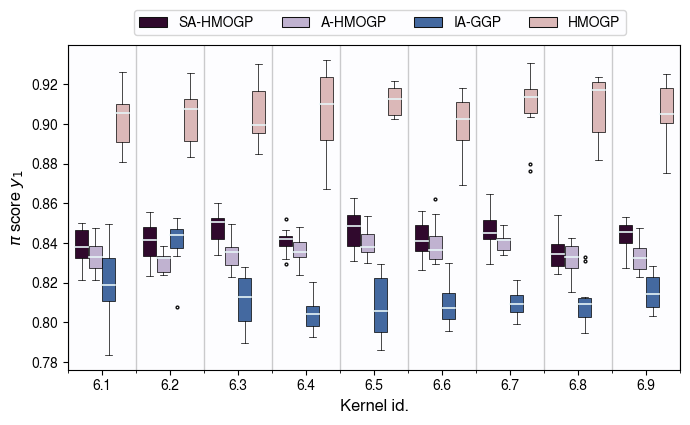

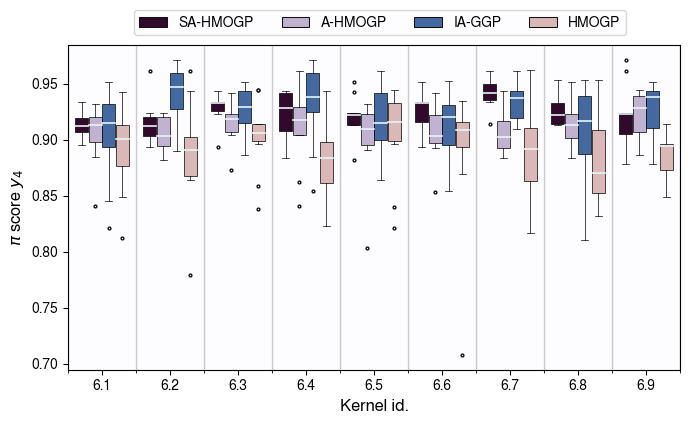

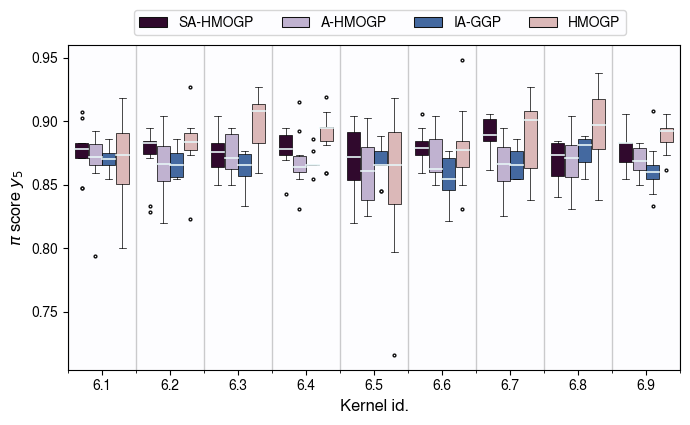

In [8]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':1.2, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
idx = [1,4,5]
for i, y in zip(idx, agreement_cols):
    fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
    sns.boxplot(data=agreement_df6[agreement_df6.weight=="quadratic"], x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"$\pi$ score $y_{}$".format(i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_agreement.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

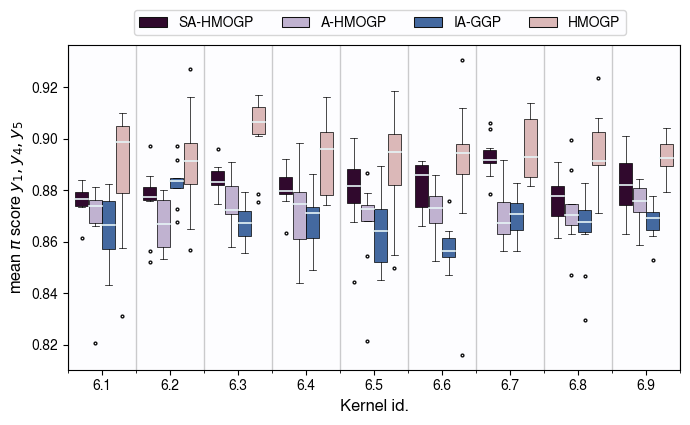

In [9]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':1.2, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
sns.boxplot(data=agreement_df6[agreement_df6.weight=="quadratic"], x="kcid", y="mean", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"mean $\pi$ score $y_1, y_4, y_5$")
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_agreement_mean.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

HD: calculate coefficient of variation

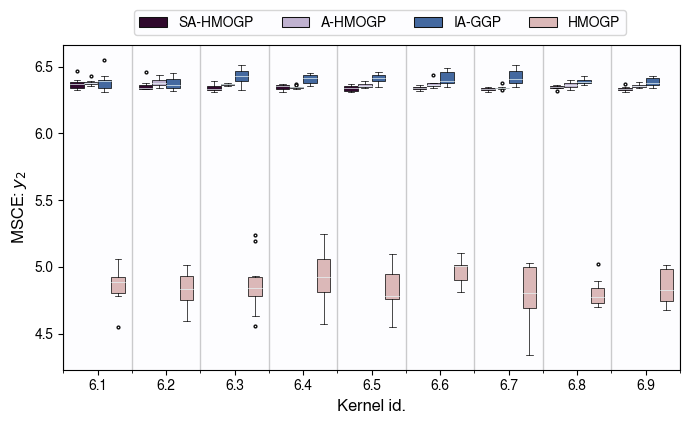

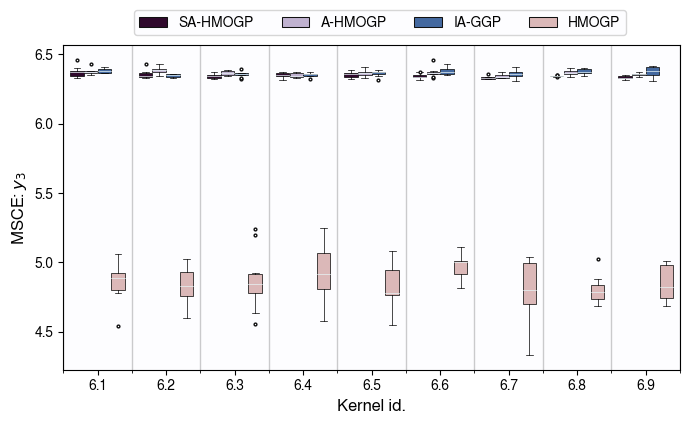

In [10]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

for i, y in enumerate(msce_cols, start=2):
    fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
    sns.boxplot(data=msce_df6, x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"MSCE: $y_{}$".format(i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_msce.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

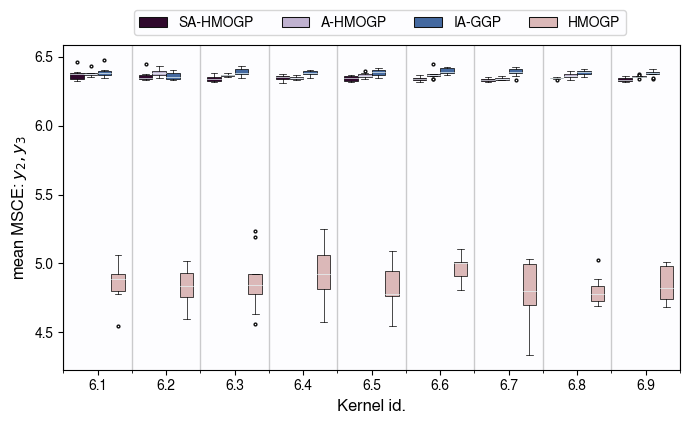

In [11]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
sns.boxplot(data=msce_df6, x="kcid", y="mean", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"mean MSCE: $y_2, y_3$")
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_msce_gm.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

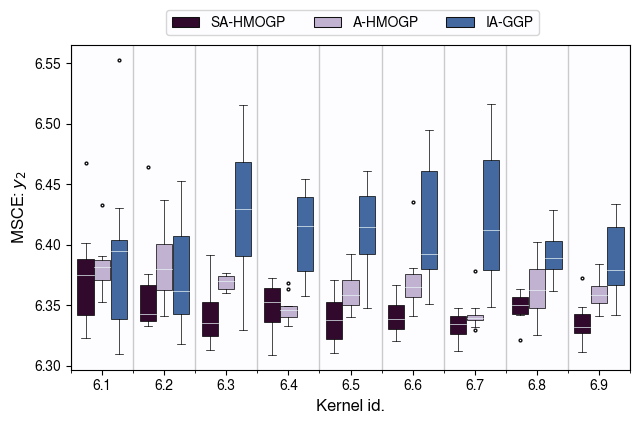

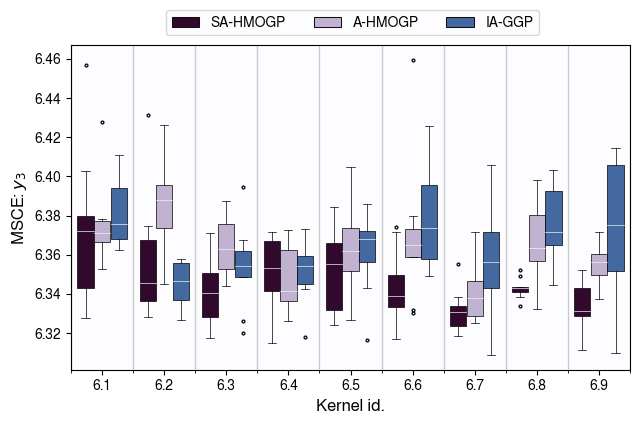

In [12]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

for i, y in enumerate(msce_cols, start=2):
    fig, ax = plt.subplots(figsize=(6.5,4), sharey=True, sharex=True)
    sns.boxplot(data=msce_df6[msce_df6.test_id!="HMOGP"], x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"MSCE: $y_{}$".format(i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_msce_additive.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

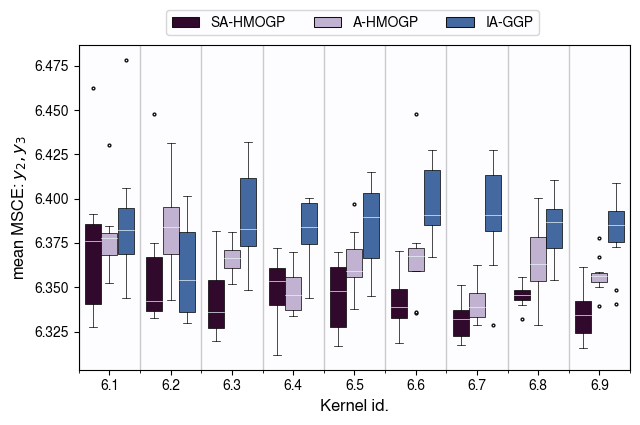

In [13]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(6.5,4), sharey=True, sharex=True)
sns.boxplot(data=msce_df6[msce_df6.test_id!="HMOGP"], x="kcid", y="mean", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"mean MSCE: $y_2, y_3$")
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_msce_gm_additive.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

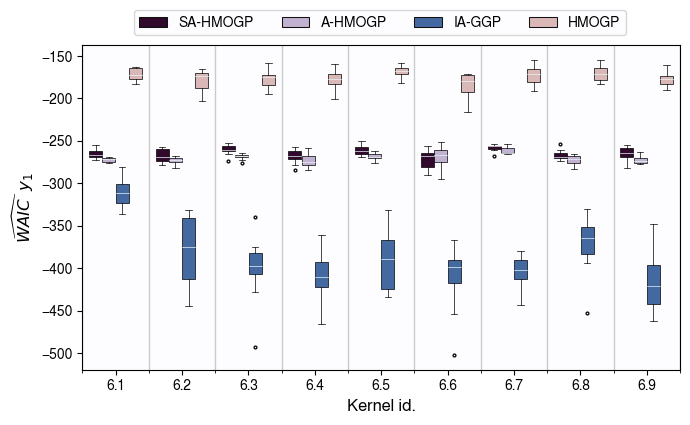

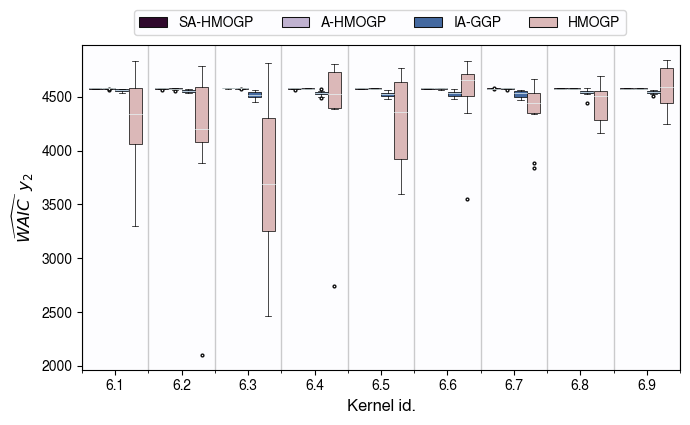

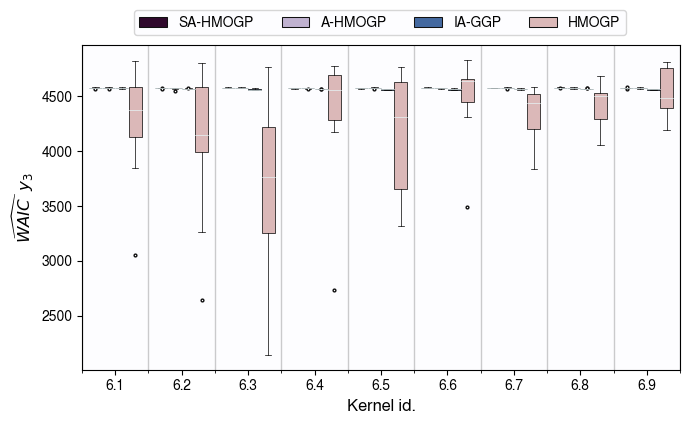

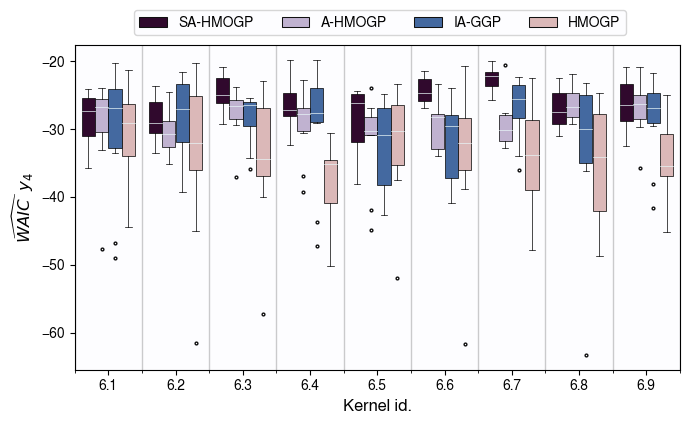

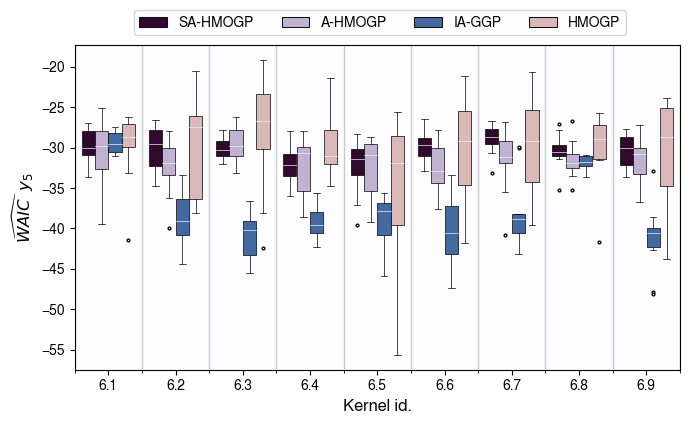

In [14]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

for i, y in enumerate(waic_cols, start=1):
    fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
    sns.boxplot(data=waic_df6, x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_waic.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

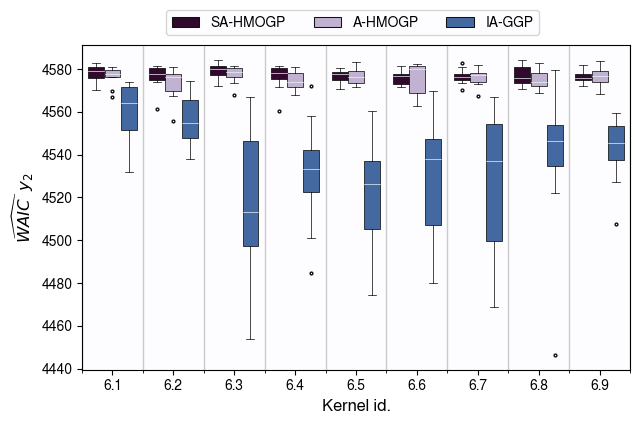

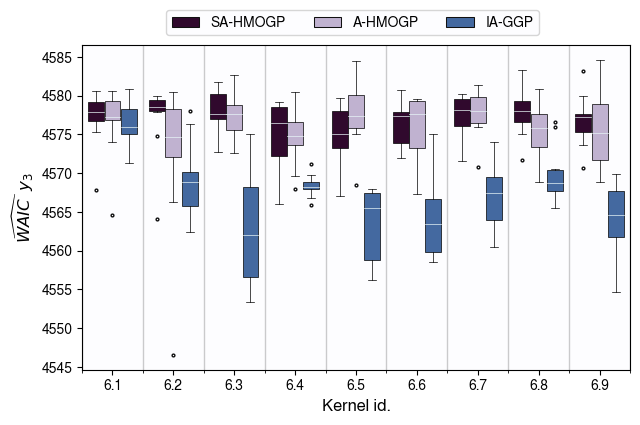

In [15]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

for i, y in enumerate(waic_cols[1:3], start=2):
    fig, ax = plt.subplots(figsize=(6.5,4), sharey=True, sharex=True)
    sns.boxplot(data=waic_df6[waic_df6.test_id!="HMOGP"], x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_waic_additive.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

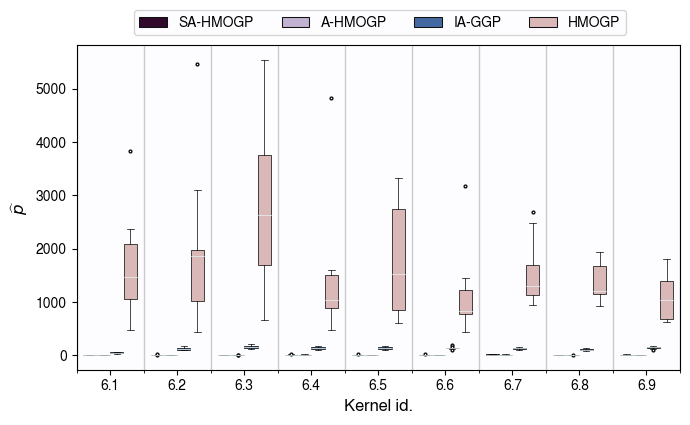

In [16]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
sns.boxplot(data=waic_df6, x="kcid", y="p_waic", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_effective_n_param.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

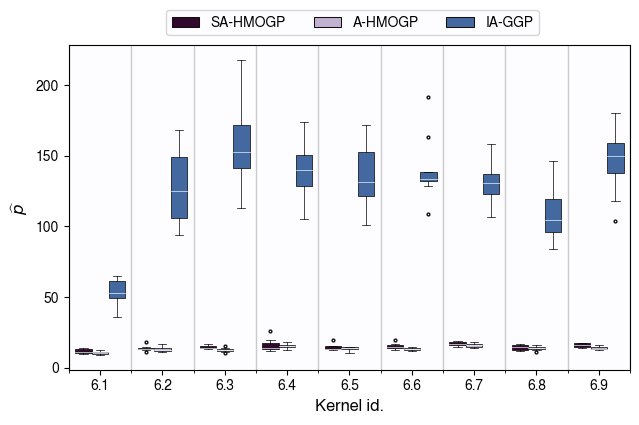

In [17]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(6.5,4), sharey=True, sharex=True)
sns.boxplot(data=waic_df6[waic_df6.test_id!="HMOGP"], x="kcid", y="p_waic", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_effective_n_param_additive.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

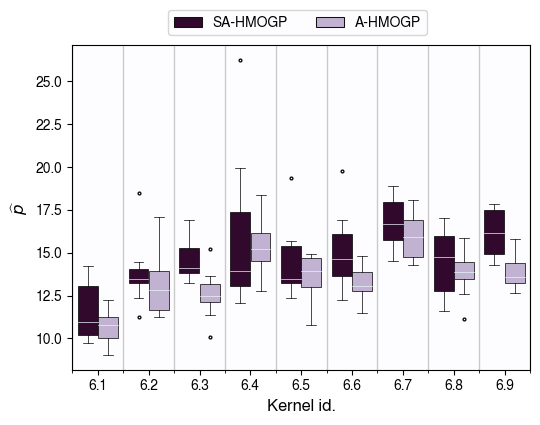

In [18]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(5.5,4), sharey=True, sharex=True)
sns.boxplot(data=waic_df6[~waic_df6.test_id.isin(["HMOGP","IA-GGP"])], x="kcid", y="p_waic", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_effective_n_param_sparse_additive.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

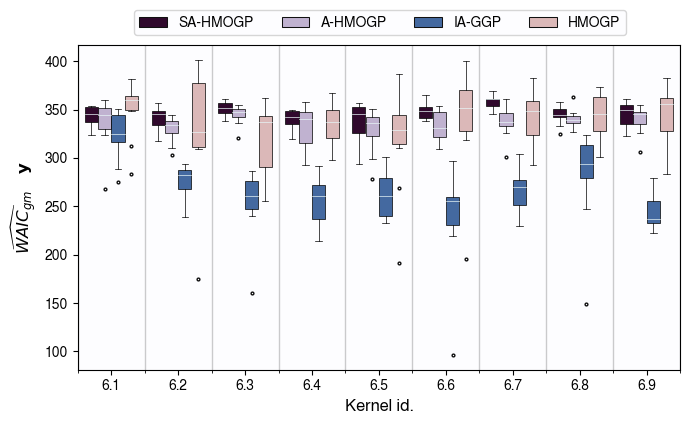

In [19]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
sns.boxplot(data=waic_gm_df6, x="kcid", y="adj_elpd_waic", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"${{\widehat{{{}}}}}_{{gm}}$    $\mathbf{{y}}$".format("WAIC"))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_waic_gm.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

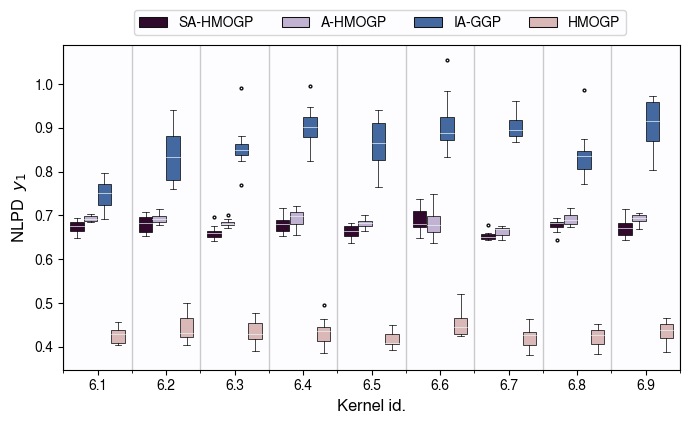

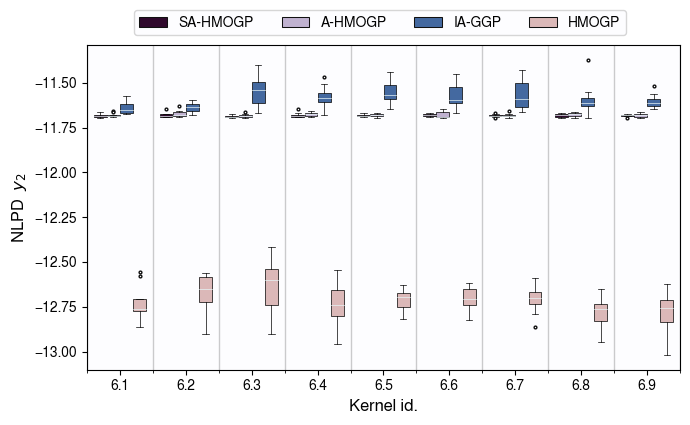

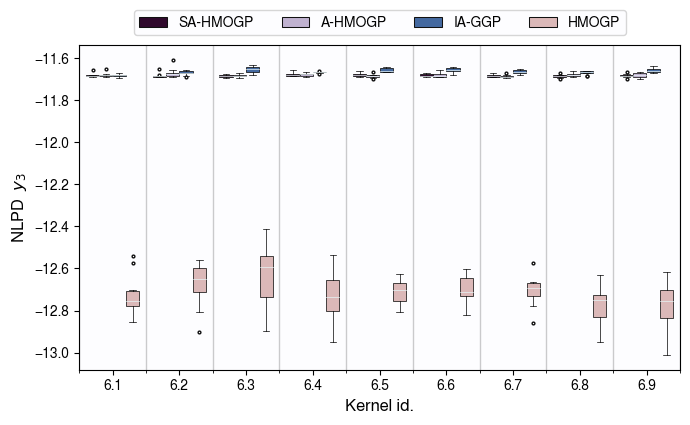

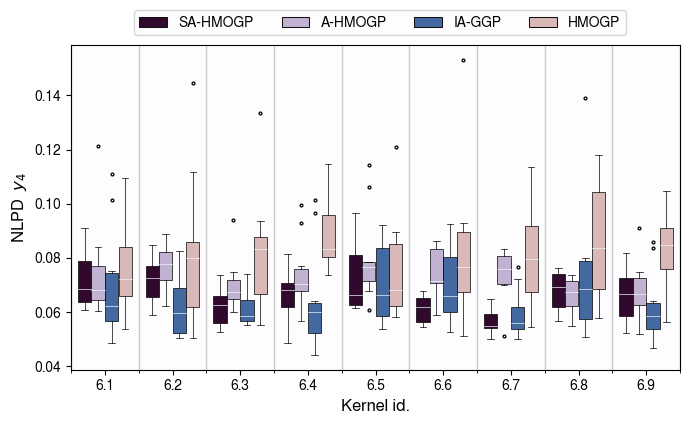

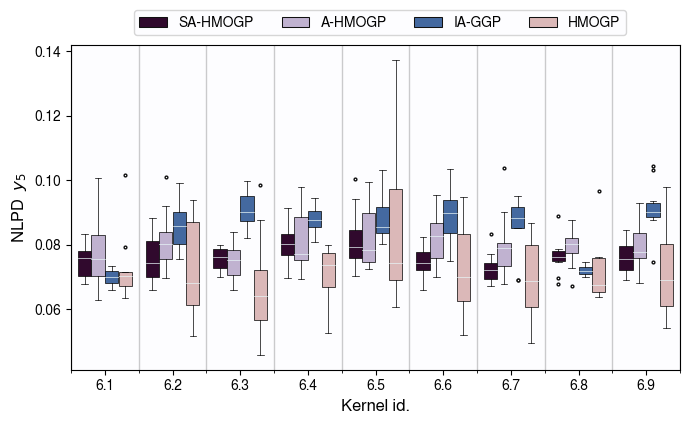

In [20]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

for i, y in enumerate(nlpd_cols, start=1):
    fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
    sns.boxplot(data=nlpd_df6, x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.set_ylabel(r"NLPD  $y_{}$".format(i))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    fig.tight_layout()
    
    if savefig:
        filename = f"kernel{kernel_n}_y{i}_nlpd.pdf"
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

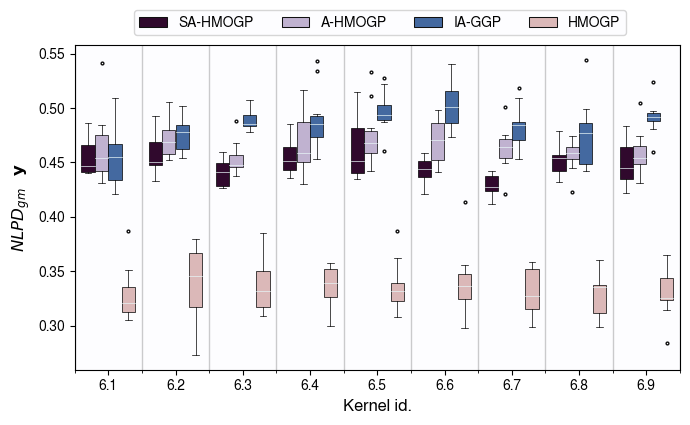

In [21]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,4), sharey=True, sharex=True)
sns.boxplot(data=nlpd_gm_df6, x="kcid", y="adj_nlpd", hue="test_id", ax=ax, palette=palette, **props)
ax.get_legend().remove()
ax.set_ylabel(r"${{{}}}_{{{}}}$   $\mathbf{{y}}$".format("NLPD", "gm", i))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ax.set_xlabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_y_nlpd_gm.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

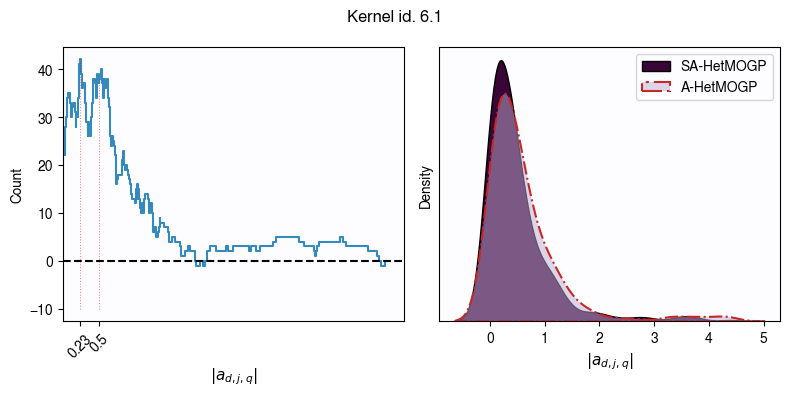

In [22]:
lmc0 = lmc_df6[(lmc_df6.test_id==test_id[0]) & (lmc_df6.kcid==6.1)].lmc_coeff.iloc[0]
lmc0 =  np.array([float(i) for i in lmc0.strip('[|]').split()])
lmc1 = lmc_df6[(lmc_df6.test_id==test_id[1]) & (lmc_df6.kcid==6.1)].lmc_coeff.iloc[0]
lmc1 =  np.array([float(i) for i in lmc1.strip('[|]').split()])

fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharey=False, sharex=False)
xticks = [0.23, 0.5, ]
plot_cdaf(lmc0, lmc1, ax=ax[0], show_vline=True, xticks=xticks, rotate_xticks=45, return_plot_values=False)
ax[0].set_ylabel("Count", fontsize=10)
ax[0].set_xlabel(r"$|a_{d,j,q}|$", fontsize=11)
ax[0].tick_params(axis='both', which='major', labelsize=10)
# ax[0].set_ylim(-5,60)

sns.kdeplot(np.abs(lmc0), ax=ax[1], fill=True, label="SA-HetMOGP", color=palette["SA-HMOGP"], alpha=.99, edgecolor='k', lw=1)
sns.kdeplot(np.abs(lmc1), ax=ax[1], fill=True, label="A-HetMOGP", color=palette["A-HMOGP"], alpha=.5, lw=1.5, edgecolor='#C62828', ls='-.')
ax[1].set_ylabel("Density", fontsize=10)
ax[1].set_yticks([])
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_xlabel(r"$|a_{d,j,q}|$", fontsize=11)
ax[1].legend(fontsize=10)

fig.suptitle("Kernel id. 6.1", fontsize=12)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_cdaf.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

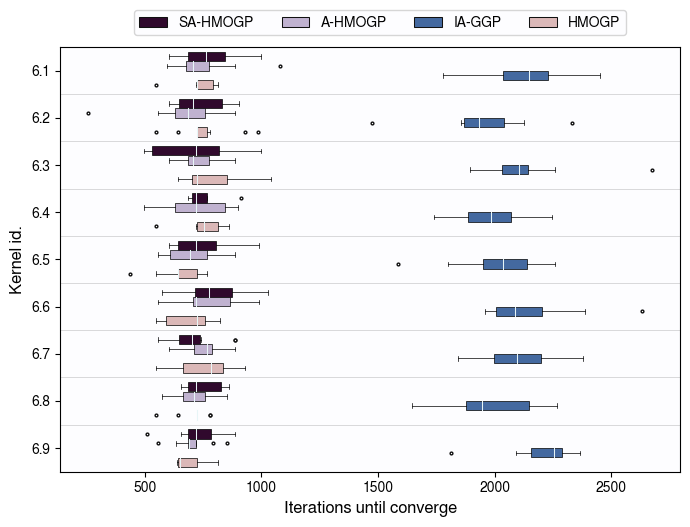

In [23]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.75, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,5), sharey=True, sharex=True)
sns.boxplot(data=compute_times_df6, y="kcid", x="iterations_to_converge", hue="test_id", ax=ax, palette=palette, orient="h", **props)
ax.get_legend().remove()
ax.set_xlabel("Iterations until converge")
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
[ax.axhline(y+.5,color='k', lw=.5, linestyle='-', alpha=.2) for y in ax.get_yticks()]
ax.set_ylabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .98), ncol=4, fontsize=10)
fig.tight_layout()

# if savefig:
#     fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_iter_converge.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

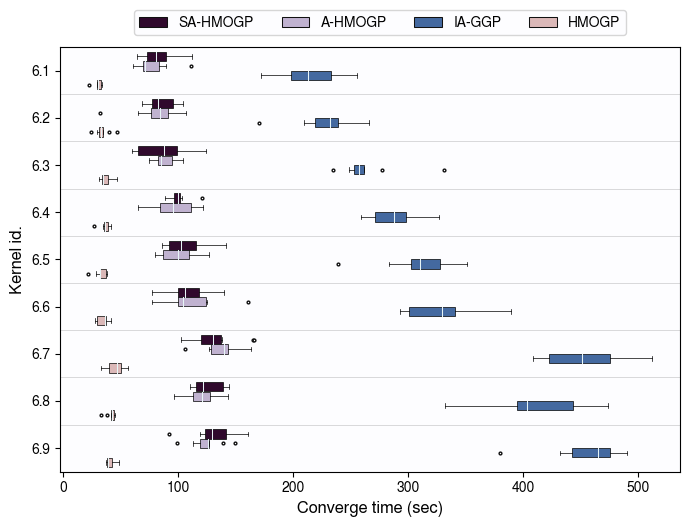

In [24]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.75, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,5), sharey=True, sharex=True)
sns.boxplot(data=compute_times_df6, y="kcid", x="time_to_converge", hue="test_id", ax=ax, palette=palette, orient="h", **props)
ax.get_legend().remove()
ax.set_xlabel("Converge time (sec)")
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
[ax.axhline(y+.5,color='k', lw=.5, linestyle='-', alpha=.2) for y in ax.get_yticks()]
ax.set_ylabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .98), ncol=4, fontsize=10)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_compute_time.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [32]:
import re
kcid_list = kernel_structure_df6.kcid.unique()
for kcid in kcid_list:
    kcid_str = kernel_structure_df6[(kernel_structure_df6.test_id=="SA-HMOGP") &
                     (kernel_structure_df6.kcid==kcid)]["kernel_structure"].iloc[0]

    kcid_str = [kc_str.strip("\s '") for kc_str in kcid_str.strip("[|]").split(",")][0]
    kcid_str = re.sub(r"\(\d\)", "{(p)}", kcid_str)
    for k in ["SE", "PPoly2", "M52"]:
        if k in kcid_str:
            new_str = "\\text{" + k + "}"
            kcid_str = kcid_str.replace(f"{k}", new_str)
    print(str(kcid) + " & " + "$" + kcid_str + "$ " + "\\" + "\\")

6.1 & $\text{SE}_1^{(p)} + \text{SE}_2^{(p)} + \text{SE}_3^{(p)} + \text{SE}_4^{(p)} + \text{SE}_5^{(p)} + \text{SE}_6^{(p)}$ \\
6.2 & $\text{SE}_1^{(p)} + \text{SE}_2^{(p)} + \text{M52}_1^{(p)} + \text{SE}_3^{(p)} + \text{SE}_4^{(p)} + \text{M52}_2^{(p)}$ \\
6.3 & $\text{SE}_1^{(p)} + \text{SE}_2^{(p)} + \text{PPoly2}_1^{(p)} + \text{SE}_3^{(p)} + \text{SE}_4^{(p)} + \text{PPoly2}_2^{(p)}$ \\
6.4 & $\text{SE}_1^{(p)} + \text{PPoly2}_1^{(p)} + \text{M52}_1^{(p)} + \text{SE}_2^{(p)} + \text{PPoly2}_2^{(p)} + \text{M52}_2^{(p)}$ \\
6.5 & $\text{SE}_1^{(p)} x \text{PPoly2}_1^{(p)} + \text{SE}_2^{(p)} + \text{SE}_3^{(p)} + \text{SE}_4^{(p)} x \text{PPoly2}_2^{(p)} + \text{SE}_5^{(p)} + \text{SE}_6^{(p)}$ \\
6.6 & $\text{SE}_1^{(p)} x \text{M52}_1^{(p)} + \text{SE}_2^{(p)} + \text{SE}_3^{(p)} + \text{SE}_4^{(p)} x \text{M52}_2^{(p)} + \text{SE}_5^{(p)} + \text{SE}_6^{(p)}$ \\
6.7 & $\text{SE}_1^{(p)} x \text{PPoly2}_1^{(p)} + \text{SE}_2^{(p)} x \text{PPoly2}_2^{(p)} + \text{SE}_3^{(p)} + \

In [33]:
for kcid in kcid_list:
    kcid_str = kernel_structure_df6[(kernel_structure_df6.test_id=="HMOGP") &
                     (kernel_structure_df6.kcid==kcid)]["kernel_structure"].iloc[0]

    kcid_str = [kc_str.strip("\s '") for kc_str in kcid_str.strip("[|]").split(",")][0]
    kcid_str = re.sub(r"\^\(\d\)", "", kcid_str)
    for k in ["SE", "PPoly2", "M52"]:
        if k in kcid_str:
            new_str = "\\text{" + k + "}"
            kcid_str = kcid_str.replace(f"{k}", new_str)
    print(str(kcid) + " & " + "$" + kcid_str + "$ " + "\\" + "\\")

6.1 & $\text{SE}_1 + \text{SE}_2 + \text{SE}_3 + \text{SE}_4 + \text{SE}_5 + \text{SE}_6$ \\
6.2 & $\text{SE}_1 + \text{SE}_2 + \text{M52}_1 + \text{SE}_3 + \text{SE}_4 + \text{M52}_2$ \\
6.3 & $\text{SE}_1 + \text{SE}_2 + \text{PPoly2}_1 + \text{SE}_3 + \text{SE}_4 + \text{PPoly2}_2$ \\
6.4 & $\text{SE}_1 + \text{PPoly2}_1 + \text{M52}_1 + \text{SE}_2 + \text{PPoly2}_2 + \text{M52}_2$ \\
6.5 & $\text{SE}_1 x \text{PPoly2}_1 + \text{SE}_2 + \text{SE}_3 + \text{SE}_4 x \text{PPoly2}_2 + \text{SE}_5 + \text{SE}_6$ \\
6.6 & $\text{SE}_1 x \text{M52}_1 + \text{SE}_2 + \text{SE}_3 + \text{SE}_4 x \text{M52}_2 + \text{SE}_5 + \text{SE}_6$ \\
6.7 & $\text{SE}_1 x \text{PPoly2}_1 + \text{SE}_2 x \text{PPoly2}_2 + \text{SE}_3 + \text{SE}_4 x \text{PPoly2}_3 + \text{SE}_5 x \text{PPoly2}_4 + \text{SE}_6$ \\
6.8 & $\text{SE}_1 x \text{M52}_1 + \text{SE}_2 x \text{M52}_2 + \text{SE}_3 + \text{SE}_4 x \text{M52}_3 + \text{SE}_5 x \text{M52}_4 + \text{SE}_6$ \\
6.9 & $\text{SE}_1 x \text{PPoly2}_1 +

In [54]:
cm = np.arange(16).reshape((4,4))
weighted_matrix, _ = scotts_pi(cm, weight_type="quadratic", return_weights=True)
unweighted_matrix, _ = scotts_pi(cm, weight_type="unweighted", return_weights=True)

In [53]:
np.round(weighted_matrix,2)

array([[1.  , 0.89, 0.56, 0.  ],
       [0.89, 1.  , 0.89, 0.56],
       [0.56, 0.89, 1.  , 0.89],
       [0.  , 0.56, 0.89, 1.  ]])

In [55]:
np.round(unweighted_matrix,2)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [56]:
cm = np.arange(4).reshape((2,2))
weighted_matrix, _ = scotts_pi(cm, weight_type="quadratic", return_weights=True)
unweighted_matrix, _ = scotts_pi(cm, weight_type="unweighted", return_weights=True)

In [57]:
np.round(weighted_matrix,2)

array([[1., 0.],
       [0., 1.]])

In [58]:
np.round(unweighted_matrix,2)

array([[1., 0.],
       [0., 1.]])